In [1]:
import glob
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdatesx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from typing import List

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# COVID-19 Daily Observation Data

Data from [2019 Novel Coronavirus COVID-19 (2019-nCoV) Data repository](https://github.com/CSSEGISandData/COVID-19) by Johns Hopkins CSSE.

## Load data
We're going to read in all of the data in the [csse_covid_19_daily_reports](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports) directory, and aggregate it into a single `DataFrame`.

First, the dates across the files aren't in a consistent format, so we need a utility to normalize our dates:

In [3]:
def normalize_date(date: str) -> pd.Timestamp:
    """Converts various timestamps into consistent format."""
    return pd.Timestamp(date).replace(hour=0, minute=0, second=0)

assert normalize_date("1/22/2020 17:00") == pd.Timestamp("2020-01-22 00:00:00")
assert normalize_date("01/22/2020 02:00") == pd.Timestamp("2020-01-22 00:00:00")
assert normalize_date("2020-02-02T23:43:02") == pd.Timestamp("2020-02-02 00:00:00")
assert normalize_date("2020-03-23 23:19:34") == pd.Timestamp("2020-03-23 00:00:00")

There are a couple more utilities we need to read in the data:

In [4]:
def list_source_files(dir_name: str) -> List[str]: 
    """Returns a list of all the source files."""
    pattern = r"(\d{2}-\d{2}-\d{4}).csv"
    src = "{}/*.csv".format(dir_name)
    return [f for f in glob.glob(src) if re.search(pattern, f)]

def read_combined_daily_data(file_names: List[str], rename_cols_map):
    """Reads in all the data, combines it in single DataFrame."""
    # Note handling inconsistent column names
    dfs = [pd.read_csv(f).rename(columns=rename_cols_map) for f in files] 
    data = pd.concat(dfs)
    return data

Now we can read in the data, aggregate it, and clean it up:

In [5]:
DIR = "csse_covid_19_daily_reports"

RENAME_COLS = { 'Country_Region': 'Country/Region', 'Province_State': 'Province/State', 
          'Last_Update': 'Last Update'}

# Read in data as single DataFrame
files = list_source_files(DIR)
data = read_combined_daily_data(files, RENAME_COLS)

# Cleanup: select columns NaN -> 0
NUMERIC_COLS = ['Confirmed', 'Deaths', 'Recovered']
data[NUMERIC_COLS] = data[NUMERIC_COLS].fillna(0)
    
# Cleanup: drop anything without cases (removes an error for DC data)
data = data[data['Confirmed'] > 0]

# Cleanup: Augment data with normalized "Date" field
data['Last Update'] = data['Last Update'].apply(normalize_date)

COLUMNS_TO_KEEP = ['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered']

# Cleanup: remove unused columns
data = data[COLUMNS_TO_KEEP]

# This is time series data, so update index and sort
data = data.set_index('Last Update')
data = data.sort_values(by=['Last Update'])

data

,Province/State,Country/Region,Confirmed,Deaths,Recovered
Last Update,,,,,
2020-01-22,Macau,Macau,1.0,0.0,0.0
2020-01-22,NaN,South Korea,1.0,0.0,0.0
2020-01-22,NaN,Thailand,2.0,0.0,0.0
2020-01-22,NaN,Japan,2.0,0.0,0.0
2020-01-22,Zhejiang,Mainland China,10.0,0.0,0.0
...,...,...,...,...,...
2020-03-26,Washington,US,86.0,4.0,0.0
2020-03-26,Arkansas,US,1.0,0.0,0.0
2020-03-26,Georgia,US,1.0,0.0,0.0


Given we set `Last Update` to be the index, we can now access data using date ranges:

In [6]:
data.loc['2020-03-19':'2020-03-21']

,Province/State,Country/Region,Confirmed,Deaths,Recovered
Last Update,,,,,
2020-03-19,NaN,India,194.0,4.0,15.0
2020-03-19,NaN,Fiji,1.0,0.0,0.0
2020-03-19,NaN,South Africa,150.0,0.0,0.0
2020-03-19,Tennessee,US,154.0,0.0,0.0
2020-03-19,NaN,Iraq,192.0,13.0,43.0
...,...,...,...,...,...
2020-03-21,North Carolina,US,253.0,0.0,0.0
2020-03-21,Victoria,Australia,229.0,0.0,8.0
2020-03-21,Wisconsin,US,282.0,4.0,0.0


## Confirmed cases

In [109]:
# Source for date formatting legibility tricks: https://stackoverflow.com/a/43631028
def plot_time_series_data(x_col, y_col):
    """Renders a line graph for time series data, making graph more legible"""
    fig, ax = plt.subplots()
    ax.plot(x_col, y_col)
    
    # make dates legible
    myFmt = DateFormatter("%m/%d")
    ax.xaxis.set_major_formatter(myFmt)
    
    # rotate dates to improve legibility
    fig.autofmt_xdate()
    plt.show()

Let's look at worldwide cumulative confirmed cases:

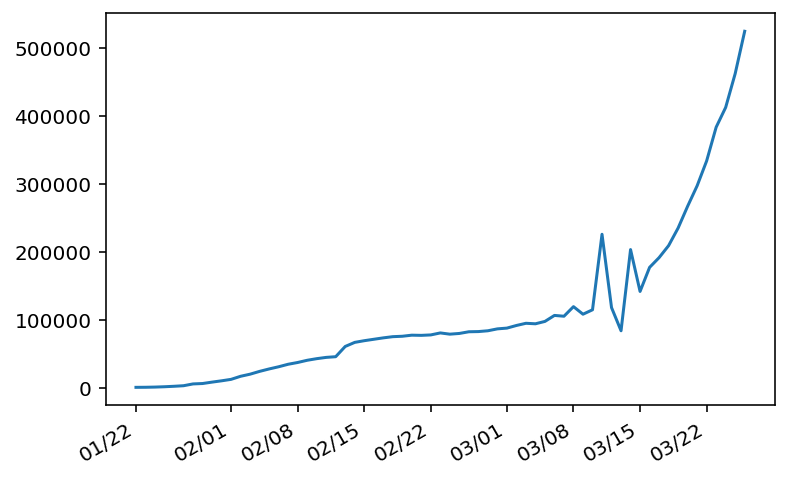

In [53]:
world = data.groupby(data.index).sum()[NUMERIC_COLS]
plot_time_series_data(world.index, world["Confirmed"])

The daily confirmed worldwide cases are noisy between 3/11 and 3/16:

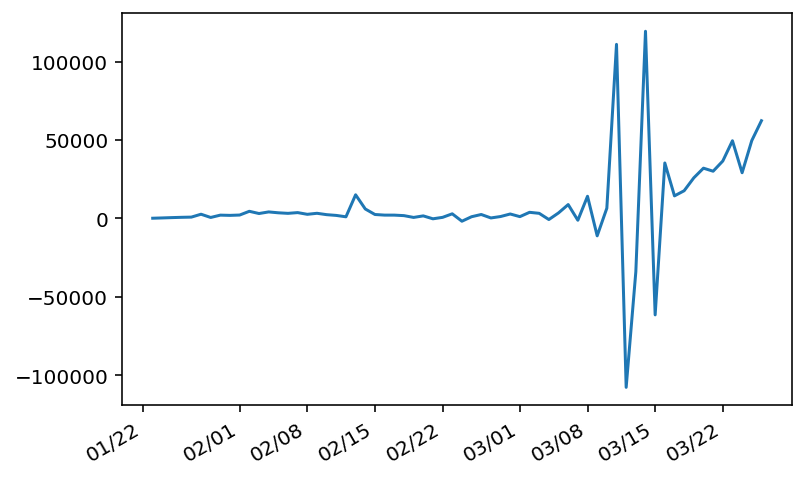

In [110]:
plot_time_series_data(world.index, world["Confirmed"].diff())

We're going to apply a function that removes outliers:

In [111]:
# Is there a better way?
def remove_value(label, df, iteration, deltas, val):
    date = df.index[deltas == val].tolist()[0]
    print("Iteration #{}: found {} change of {} on {}".format(iteration, label, val, date))
    date_idx = df.index.get_loc(date)
    return df.drop(df.index[date_idx])

def remove_outliers(df_original, col_name, iterations): 
    df = df_original.copy()
    """Repeatedly removes minimum and maximum values"""
    
    for i in range(0, iterations):
        deltas = df[col_name].diff()
        df = remove_value("max", df, i, deltas, deltas.max())
        deltas = df[col_name].diff()
        df = remove_value("min", df, i, deltas, deltas.min())
    
    return df

The daily occurances are still surprisingly noisy, given this data is aggregated:

Iteration #0: found max change of 119353.0 on 2020-03-14 00:00:00
Iteration #0: found min change of -107776.0 on 2020-03-12 00:00:00
Iteration #1: found max change of 111003.0 on 2020-03-11 00:00:00
Iteration #1: found min change of -30833.0 on 2020-03-13 00:00:00
Iteration #2: found max change of 62291.0 on 2020-03-26 00:00:00
Iteration #2: found min change of -11130.0 on 2020-03-09 00:00:00


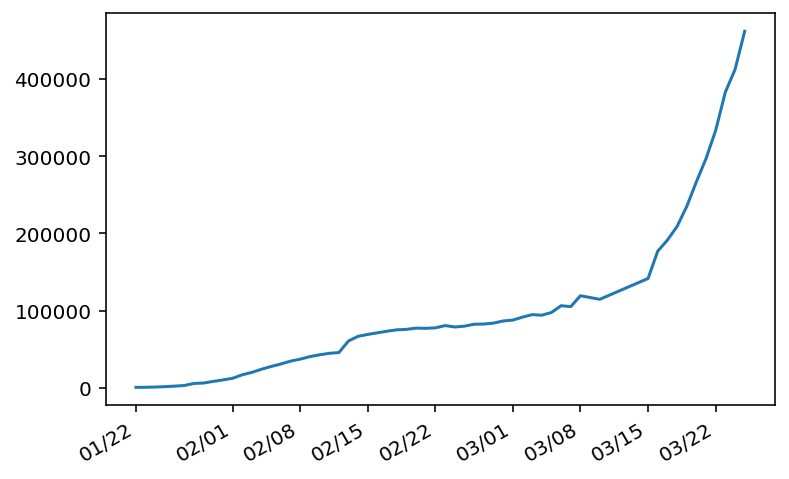

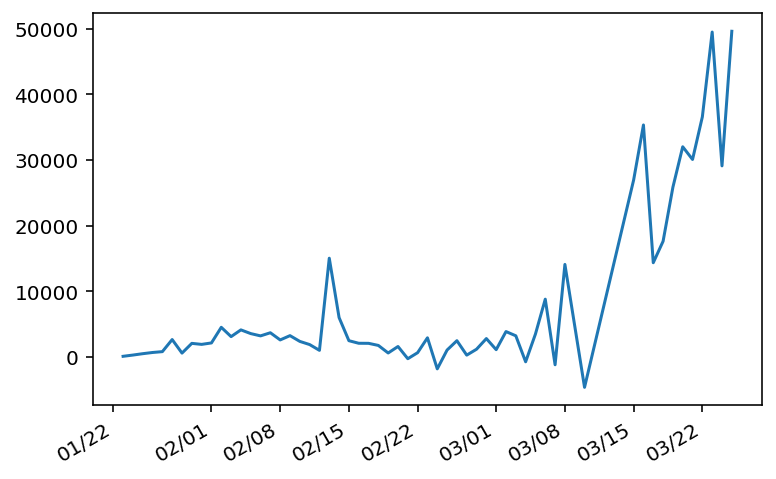

In [112]:
world_smooth = remove_outliers(world, "Confirmed", 3) # number of iterations = suspicious peaks & valleys
plot_time_series_data(world_smooth.index, world_smooth["Confirmed"]) 
plot_time_series_data(world_smooth.index, world_smooth["Confirmed"].diff()) 

Let's look at **Hubei** confirmed cases:

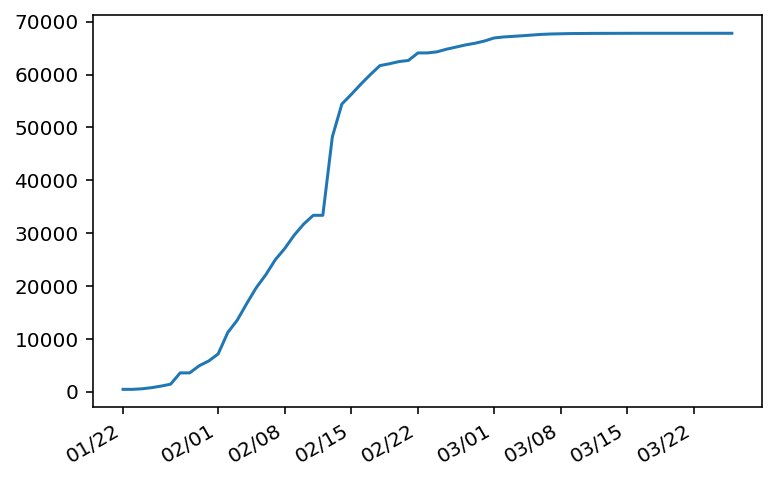

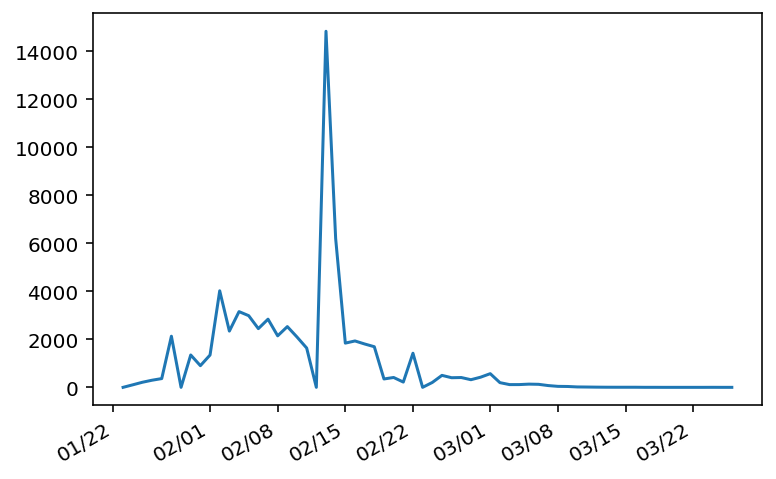

In [94]:
hubei = data.loc[data['Province/State'] == 'Hubei',NUMERIC_COLS]
plot_time_series_data(hubei.index, hubei["Confirmed"])
plot_time_series_data(hubei.index, hubei["Confirmed"].diff())

The daily confirmed cases is noisy; however, unlike worldwide views, removing outliers would exacerbate the issue, there's a very steep increase in cases between 2/12 - 2/14.

Let's look at cumulative confirmed cases in **Italy**:

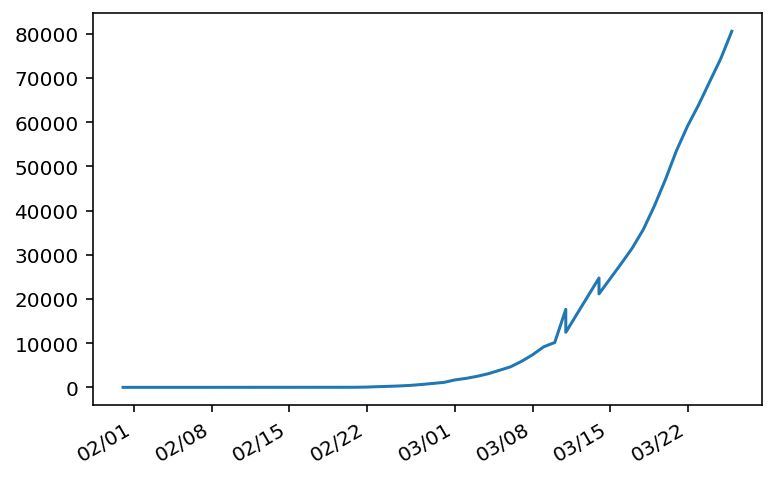

In [104]:
italy = data.loc[data['Country/Region'] == 'Italy']
plot_time_series_data(italy.index, italy["Confirmed"])

Italian daily occurrances are also noisy:

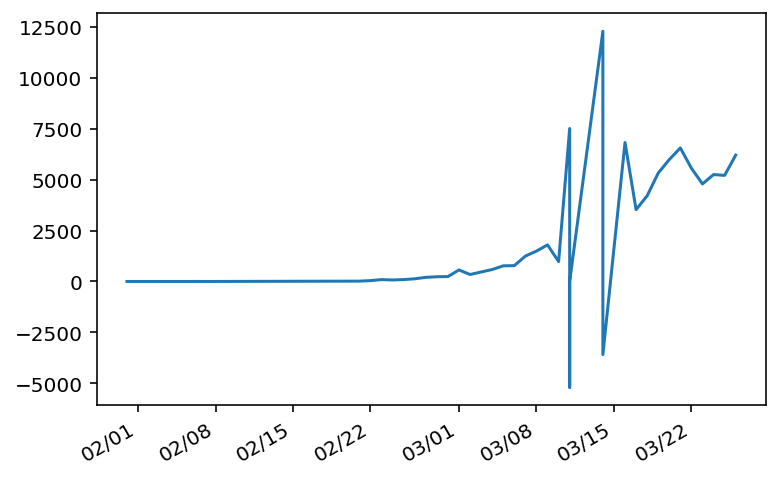

In [105]:
plot_time_series_data(italy.index, italy["Confirmed"].diff())

Let's remove the two spikes:

Iteration #0: found max change of 12285.0 on 2020-03-14 00:00:00
Iteration #0: found min change of -5198.0 on 2020-03-11 00:00:00
Iteration #1: found max change of 17831.0 on 2020-03-16 00:00:00
Iteration #1: found min change of 0.0 on 2020-01-31 00:00:00


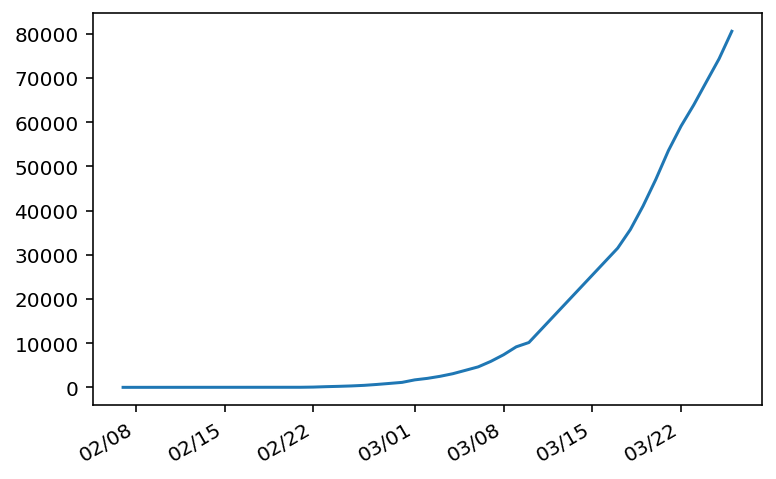

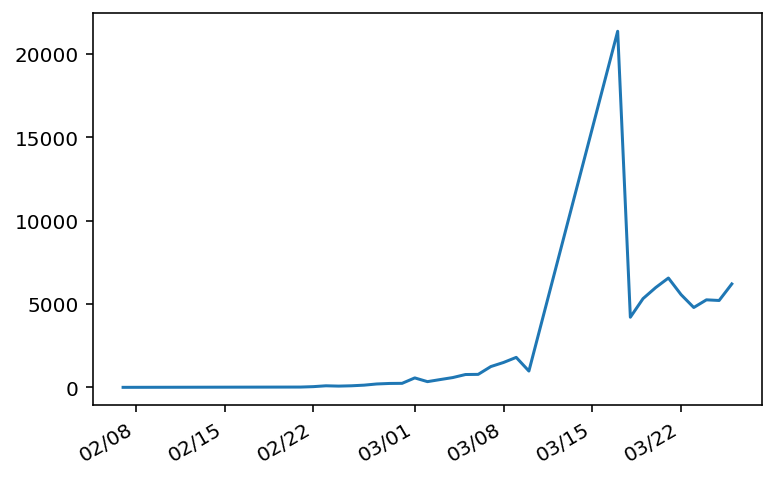

In [113]:
italy_smooth = remove_outliers(italy, "Confirmed", 2) # number of iterations = suspicious peaks & valleys
plot_time_series_data(italy_smooth.index, italy_smooth["Confirmed"]) 
plot_time_series_data(italy_smooth.index, italy_smooth["Confirmed"].diff()) 

Let's look at **US** cumulative confirmed cases:

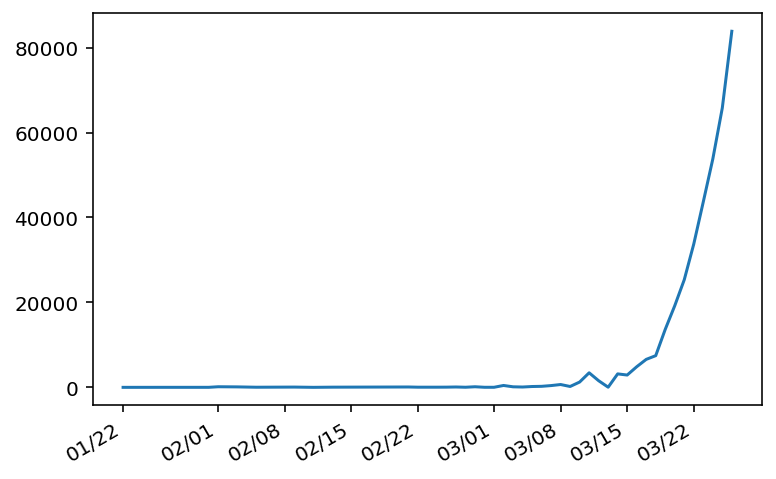

In [116]:
usa = data.loc[data['Country/Region'] == 'US']
usa = usa.groupby(usa.index).sum()
plot_time_series_data(usa.index, usa["Confirmed"])

There's some moderate unexpected noise where cumulative confirmed cases decreases, which you can see more clearly in the daily cases data:

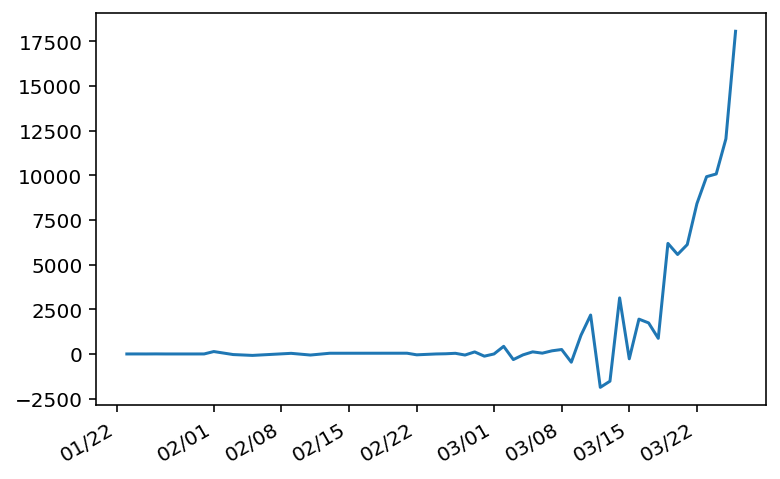

In [118]:
plot_time_series_data(usa.index, usa["Confirmed"].diff())

Unfortunately, removing spikes isn't as straightforward; the greatest increases are on 3/26 and 3/25, respectively, as a consequence of the exponential growth of the data. So we'll ignore the non-monotonic nature of the cumulative confirmed cases.

Let's look at **New York State** cumulative confirmed cases:

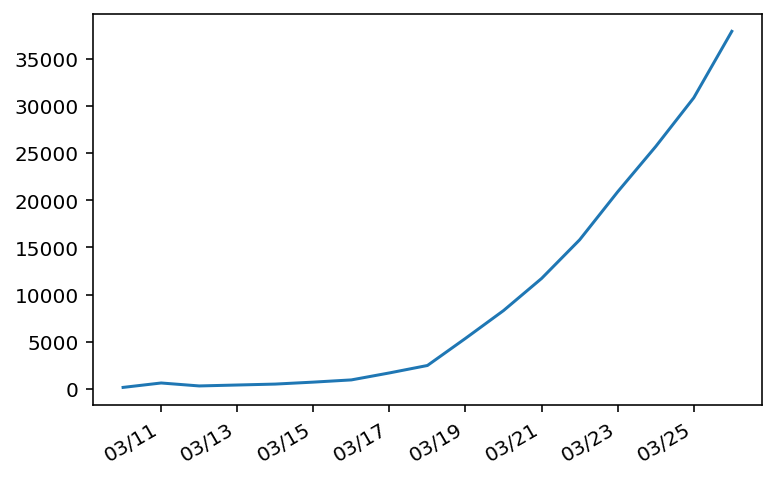

In [98]:
ny = data.loc[data['Province/State'] == 'New York']
ny = ny.groupby(ny.index).sum()
plot_time_series_data(ny.index, ny["Confirmed"])

New York daily occurances clearly show exponential trend:

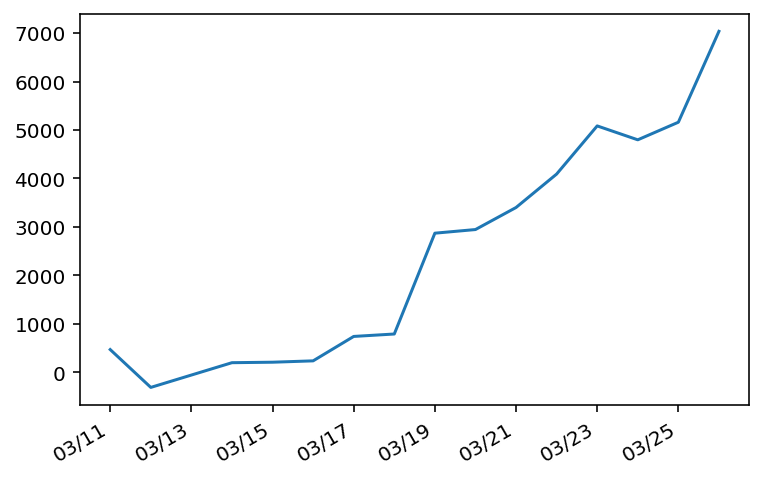

In [101]:
plot_time_series_data(ny.index, ny["Confirmed"].diff())

Let's look at **Washington DC** cumulative confirmed cases:

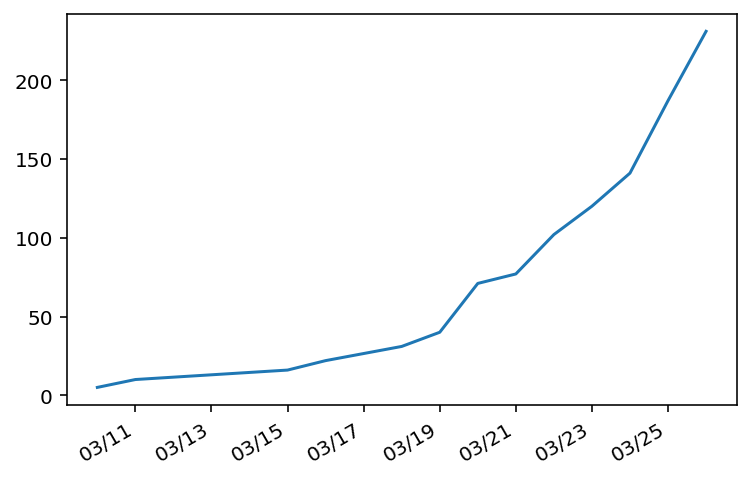

In [63]:
dc = data.loc[data['Province/State'] == 'District of Columbia']
plot_time_series_data(dc.index, dc["Confirmed"])

While daily confirmed cases are noisy, the sample size is small; and it still shows an exponential growth:

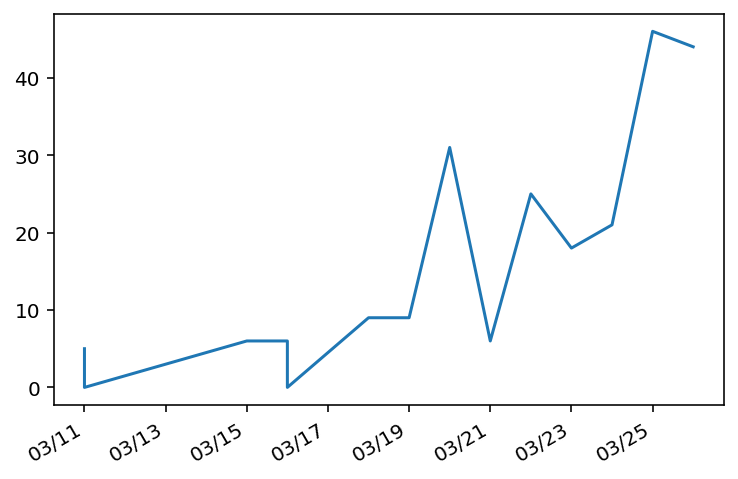

In [65]:
plot_time_series_data(dc.index, dc["Confirmed"].diff())

## Conclusions
* **Hubei**'s daily confirmed observations are very noisy, and are difficult to interpret. Since this is the first region with a COVID-19 pandemic, perhaps this is related to 
* Many other regions (including **worldwide** and **Italy**) contain non-monotonically increasing cumulative observations; it's not clear why this is the case, but these values can be smoothed by iteratively removing observations corresponding maximum or minimum daily deltas. Others (e.g., **US**) also have non-monotonically increase cumulative observations, but they cannot be cleaned using the same technique as they are
* Some regions (including **Hubei** and **Italy**) see sudden spikes of recorded cases that drop off in relatively short periods of time; these may be related to deployment of new testing capabilities, or deployment of more widespread testing.